<h1> Preprocessing using Dataflow </h1>

This notebook illustrates:
<ol>
<li> Creating datasets for Machine Learning using Dataflow
</ol>
<p>
While Pandas is fine for experimenting, for operationalization of your workflow, it is better to do preprocessing in Apache Beam. This will also help if you need to preprocess data in flight, since Apache Beam also allows for streaming.

Apache Beam only works in Python 2 at the moment, so we're going to switch to the Python 2 kernel. In the above menu, click the dropdown arrow and select `python2`. 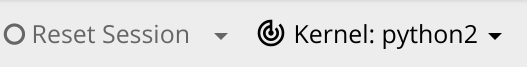

Then activate a Python 2 environment and install Apache Beam.
<p>
Some packages have versioning issues. Either install the correct version of the packages, or have to ignore the warnings
This datalab is not working/outdated due to versinoining issues

In [13]:
%%bash
source activate py2env
pip uninstall -y google-cloud-dataflow
conda install -y pytz
pip install --force apache-beam[gcp]==2.9.0 dill==0.2.6 numpy==1.14 --ignore-installed

Solving environment: ...working... done

# All requested packages already installed.

  Using cached https://files.pythonhosted.org/packages/e6/35/f187bdf23be87092bd0f1200d43d23076cee4d0dec109f195173fd3ebc79/mock-2.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/cc/3e/29f92b7aeda5b078c86d14f550bf85cff809042e3429ace7af6193c3bc9f/typing-3.6.6-py2-none-any.whl
  Using cached https://files.pythonhosted.org/packages/67/69/be1402c904506a5ec79ba65c7f0035342d506d5305cfd9ae8bc6f1c8db47/fastavro-0.21.19-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2d/99/b2c4e9d5a30f6471e410a146232b4118e697fa3ffc06d6a65efde84debd0/futures-3.2.0-py2-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b8/be/3bb6d8241b5ed1f8437169df53e7dd6ca986174e022585de15087a848c99/grpcio-1.19.0-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ea/72/5eadea03b06ca1320be2433ef2236155da17806b700efc92677

Skipping google-cloud-dataflow as it is not installed.


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.8

Please update conda by running

    $ conda update -n base -c defaults conda


datalab 1.1.3 has requirement google-cloud-monitoring==0.28.0, but you'll have google-cloud-monitoring 0.31.1 which is incompatible.
datalab 1.1.3 has requirement six==1.10.0, but you'll have six 1.12.0 which is incompatible.
google-cloud-bigtable 0.31.1 has requirement google-cloud-core<0.29dev,>=0.28.0, but you'll have google-cloud-core 0.29.1 which is incompatible.
tensorboard 1.8.0 has requirement bleach==1.5.0, but you'll have bleach 2.1.2 which is incompatible.
tensorboard 1.8.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
apache-airflow 1.9.0 has requirement funcsigs==1.0.0, but you'll have funcsigs 1.0.2 which is incompatible.
apache-airflow 1.9.0 has requirement future<0.17,>=0.16.0, but you'll have

After doing a pip install, click **"Reset Session"** on the notebook so that the Python environment picks up the new packages.

In [1]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-50f6d3e56f44c95b'
PROJECT = 'qwiklabs-gcp-50f6d3e56f44c95b'
REGION = 'australia-southeast1-a'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Create ML dataset using Dataflow </h2>
Let's use Cloud Dataflow to read in the BigQuery data, do some preprocessing, and write it out as CSV files.
In this case, I want to do some preprocessing, modifying data so that we can simulate what is known if no ultrasound has been performed. 
Note that after you launch this, the actual processing is happening on the cloud. Go to the GCP webconsole to the Dataflow section and monitor the running job. It took about 20 minutes for me.
<p>
If you wish to continue without doing this step, you can copy my preprocessed output:
<pre>
gsutil -m cp -r gs://cloud-training-demos/babyweight/preproc gs://your-bucket/
</pre>
But if you do this, you also have to use my TensorFlow model since yours might expect the fields in a different order

In [4]:
'weight_pounds,is_male,mother_age,plurality,gestation_weeks'.split(',') # might be easier way to split/add/remove list elements

['weight_pounds', 'is_male', 'mother_age', 'plurality', 'gestation_weeks']

In [1]:
import apache_beam as beam
import datetime, os

def to_csv(rowdict):
  import hashlib
  import copy

  # TODO #1:
  # Pull columns from BQ and create line(s) of CSV input
  CSV_COLUMNS = [
    'weight_pounds',
    'is_male',
    'mother_age',
    'plurality',
    'gestation_weeks'
  ]
    
  # Create synthetic data where we assume that no ultrasound has been performed
  # and so we don't know sex of the baby. Let's assume that we can tell the difference
  # between single and multiple, but that the errors rates in determining exact number
  # is difficult in the absence of an ultrasound.
  no_ultrasound = copy.deepcopy(rowdict)
  w_ultrasound = copy.deepcopy(rowdict)

  no_ultrasound['is_male'] = 'Unknown'
  if rowdict['plurality'] > 1:
    no_ultrasound['plurality'] = 'Multiple(2+)'
  else:
    no_ultrasound['plurality'] = 'Single(1)'

  # Change the plurality column to strings
  w_ultrasound['plurality'] = ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)'][rowdict['plurality'] - 1]

  # Write out two rows for each input row, one with ultrasound and one without
  for result in [no_ultrasound, w_ultrasound]:
    data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
    key = hashlib.sha224(data).hexdigest()  # hash the columns to form a key
    yield str('{},{}'.format(data, key))
    
def preprocess(in_test_mode):
  import shutil, os, subprocess
  job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')

  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './preproc'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/babyweight/preproc/'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass

  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'region': REGION,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True
  }
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  p = beam.Pipeline(RUNNER, options = opts)
    
  query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """

  if in_test_mode:
    query = query + ' LIMIT 100' 

  for step in ['train', 'eval']:
    if step == 'train':
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) < 3'.format(query)
    else:
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) = 3'.format(query)

    (p 
     ## TODO Task #2: Modify the Apache Beam pipeline such that the first part of the pipe reads the data from BigQuery
     | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query=selquery, user_standard_sql=True))
     | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
     | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
    )

  job = p.run()
  if in_test_mode:
    job.wait_until_finish()
    print("Done!")
 
# TODO Task #3: Once you have verified that the files produced locally are correct, change in_test_mode to False
#               to execute this in Cloud Dataflow
preprocess(in_test_mode = True)

ImportError: No module named apache_beam

In [ ]:
%bash
gsutil ls gs://${BUCKET}/babyweight/preproc/*-00000*

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License